Results for Y2B_23:


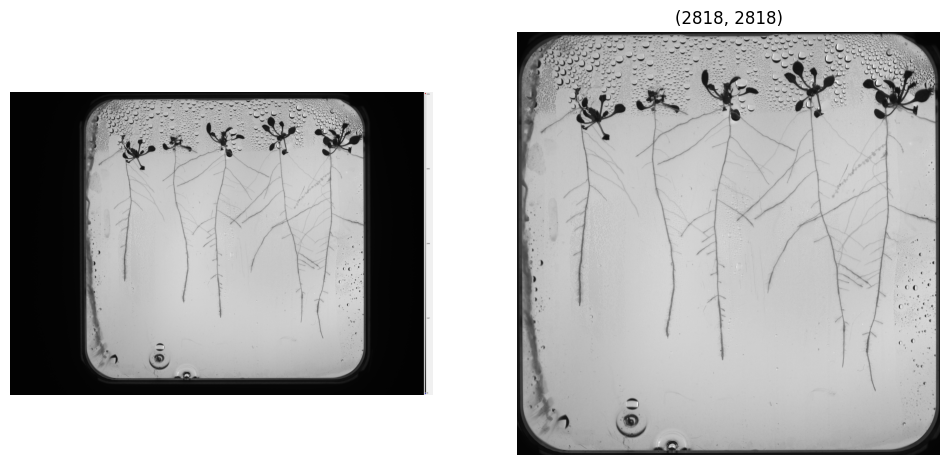

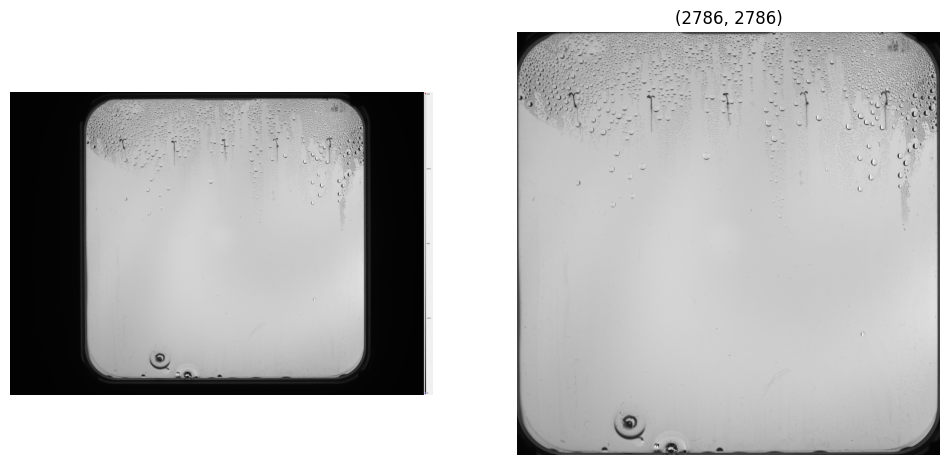

Results for Y2B_24:


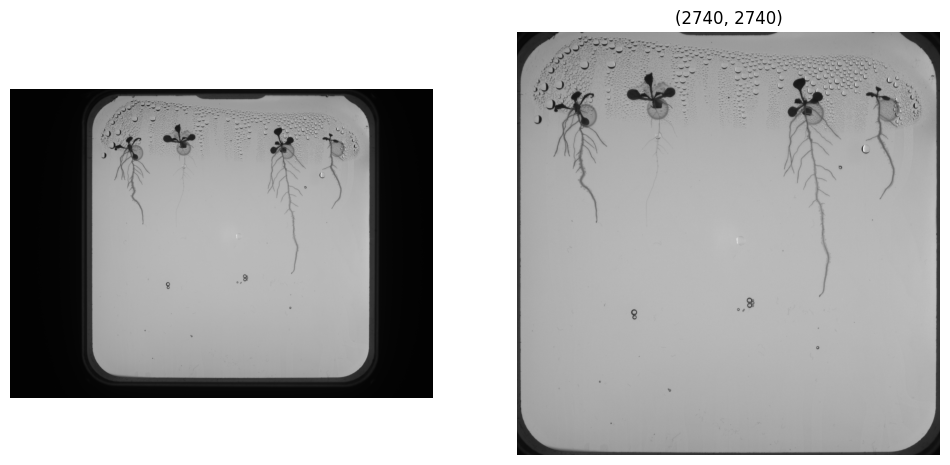

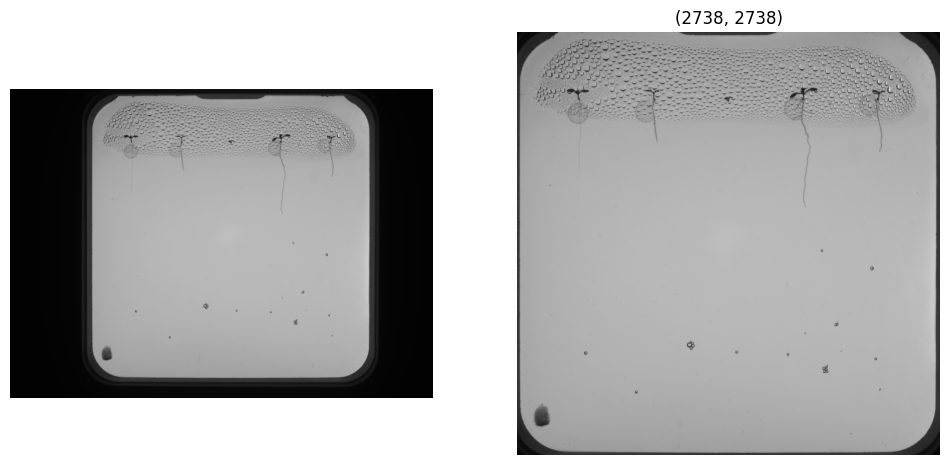

In [14]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt

def preprocess_image_custom(image, legend=False):
    """
    Preprocess the input image by removing a potential legend and applying basic enhancements.
    Args:
    - image: Input image (BGR).
    - legend: Boolean, True if the dataset has a white legend.
    Returns:
    - Preprocessed grayscale image.
    """
    h, w = image.shape[:2]
    
    # Handle legend for Y2B_23 dataset
    if legend:
        legend_width = 150  # Adjust if necessary
        legend_region = image[:, w - legend_width:]
        avg_intensity = np.mean(legend_region)  # Calculate average intensity of the legend area
        if avg_intensity > 200:  # Check if the region is bright enough to be considered a legend
            mask = np.ones((h, w), dtype=np.uint8) * 255
            mask[:, w - legend_width:] = 0  # Mask out the legend region
            image = cv2.bitwise_and(image, image, mask=mask)

    # Convert image to grayscale, apply Gaussian blur for smoothing, and enhance contrast
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    enhanced = cv2.equalizeHist(blurred)
    return enhanced

def detect_edges_custom(image):
    """
    Detect edges in the preprocessed image using combined edge detection methods.
    Args:
    - image: Preprocessed grayscale image.
    Returns:
    - Combined edge-detection image.
    """
    # Perform Canny edge detection
    edges = cv2.Canny(image, 50, 150)
    # Threshold the image to generate a binary image
    _, binary = cv2.threshold(image, 100, 255, cv2.THRESH_BINARY)
    # Combine edges and binary image for better results
    return cv2.addWeighted(edges, 0.6, binary, 0.4, 0)

def find_largest_square(image, edges):
    """
    Find the largest square-like contour in the image.
    Args:
    - image: Original image (for reference dimensions).
    - edges: Edge-detection result.
    Returns:
    - Bounding box (x, y, w, h) of the largest square-like contour.
    """
    # Find contours in the edge-detection result
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_square = None
    max_area = 0

    for contour in contours:
        # Approximate the contour to a polygon
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)

        # Compute bounding rectangle and check for square-like properties
        x, y, w, h = cv2.boundingRect(approx)
        area = w * h
        aspect_ratio = w / h

        # Check for square-like contours
        if 0.9 <= aspect_ratio <= 1.1 and area > max_area:
            max_area = area
            largest_square = (x, y, w, h)

    return largest_square

def crop_square(image, bounding_box, padding_ratio=0.04):
    """
    Crop the image to a square around the bounding box with padding.
    Args:
    - image: Original image.
    - bounding_box: Detected bounding box (x, y, w, h).
    - padding_ratio: Ratio for padding around the bounding box.
    Returns:
    - Cropped square image.
    """
    x, y, w, h = bounding_box
    size = max(w, h)
    center_x, center_y = x + w // 2, y + h // 2

    # Add padding to the square
    padding = int(size * padding_ratio)
    size = size + 2 * padding

    # Calculate square crop dimensions
    x_start = max(center_x - size // 2, 0)
    y_start = max(center_y - size // 2, 0)
    x_end = min(center_x + size // 2, image.shape[1])
    y_end = min(center_y + size // 2, image.shape[0])

    return image[y_start:y_end, x_start:x_end]

def process_single_image(image_path, legend=False, padding_ratio=0.04):
    """
    Process a single image to detect and crop the Petri dish.
    Args:
    - image_path: Path to the input image.
    - legend: Boolean, True if the dataset has a legend.
    - padding_ratio: Ratio for padding around the bounding box.
    Returns:
    - Cropped square image.
    """
    image = cv2.imread(image_path)  # Load the image
    if image is None:
        raise ValueError(f"Image not found: {image_path}")

    # Preprocess image, detect edges, and find the largest square
    preprocessed = preprocess_image_custom(image, legend)
    edges = detect_edges_custom(preprocessed)
    bounding_box = find_largest_square(image, edges)

    if bounding_box is None:
        raise ValueError(f"No Petri dish detected in {image_path}.")

    return crop_square(image, bounding_box, padding_ratio)

def process_images_in_folder(folder_path, legend=False, sample_size=2, padding_ratio=0.04):
    """
    Process multiple images from a folder.
    Args:
    - folder_path: Path to the folder containing images.
    - legend: Boolean, True if the dataset has a legend.
    - sample_size: Number of random images to process.
    - padding_ratio: Ratio for padding around the bounding box.
    Returns:
    - List of processed images.
    """
    # Get a list of image files in the folder
    image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    # Randomly select a sample of files to process
    selected_files = random.sample(image_files, min(sample_size, len(image_files)))

    results = []
    for image_path in selected_files:
        try:
            # Process each image and store the results
            cropped = process_single_image(image_path, legend, padding_ratio)
            results.append((image_path, cropped))
        except Exception as e:
            print(f"Error processing {image_path}: {e}")

    return results

def display_images(results):
    """
    Display original and cropped images side by side.
    Args:
    - results: List of tuples (image_path, cropped_image).
    """
    for image_path, cropped in results:
        original = cv2.imread(image_path)  # Load original image

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.title("Original Image")
        plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title("Cropped Image")
        plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
        plt.axis('off')

        plt.show()

# Dataset paths
path_Y2B_23 = r"C:\Users\Michon\Downloads\Y2B_23\images\train"
path_Y2B_24 = r"C:\Users\Michon\Downloads\Y2B_24\images"

# Process and display images
results_Y2B_23 = process_images_in_folder(path_Y2B_23, legend=True, sample_size=2)
results_Y2B_24 = process_images_in_folder(path_Y2B_24, legend=False, sample_size=2)

print("Results for Y2B_23:")
display_images(results_Y2B_23)

print("Results for Y2B_24:")
display_images(results_Y2B_24)
